In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install transformers

In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

import transformers
from sklearn.metrics import *
from transformers import AdamW
from tqdm.notebook import tqdm
from scipy.special import softmax
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split as tts
from transformers import BertTokenizerFast, BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AutoModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
cd drive/My Drive/Colab Notebooks/experiments

/content/drive/My Drive/Colab Notebooks/experiments


In [5]:
# Download humor detection data
# Paper: https://arxiv.org/abs/2004.12765
data = pd.read_csv("data/trofi.csv")
print("\nThere are", len(data), "sentences")

# Use the standard text/label columns
# Create labels: 1 --> humorous, 0 --> not humorous
data["label"] = data["label"].apply(int)
data.head()


There are 3737 sentences


,verb,sentence,verb_idx,label
0,absorb,An Energy Department spokesman says the sulfur...,22,0
1,absorb,The yellow beta carotene pigment absorbs blue ...,5,0
2,absorb,"This time , the ground absorbed the shock wave...",5,0
3,absorb,'' Vitamins could be passed right out of the b...,12,0
4,absorb,"As Eliot wrote : '' In a warm haze , the sultr...",14,0


In [6]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(data.iloc[0].sentence, add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)


tensor([[  101,  2019,  2943,  2533, 14056,  2758,  1996, 17864, 14384,  2453,
          2022,  7453,  8980,  3085,  2083,  1996,  2224,  1997,  9898,  2098,
          9771,  1010,  2029, 12102,  2000, 16888,  1996, 17864,   102]])
['[CLS]', 'an', 'energy', 'department', 'spokesman', 'says', 'the', 'sulfur', 'dioxide', 'might', 'be', 'simultaneously', 'recover', '##able', 'through', 'the', 'use', 'of', 'powder', '##ed', 'limestone', ',', 'which', 'tends', 'to', 'absorb', 'the', 'sulfur', '[SEP]']


In [7]:
# Use a subset for quick experiments
#subset_data = data[:10000]

# Split to train, val and test
train, test = tts(data[["sentence", "label"]], random_state=42, test_size=0.1)
train, val = tts(train, random_state=42, test_size=test.shape[0])

In [8]:
!ls -a

bert		    models			  saved_weights.pt
cache_dir	    multilingual		  stockholm
data		    norm-analysis-of-transformer  transfer_learning
.ipynb_checkpoints  preprocessing		  Transformer-Explainability
log		    reports			  uncased_L-12_H-768_A-12.zip
model		    run_language_modeling.py	  uncased_L-12_H-768_A-12.zip.1


In [9]:
cd norm-analysis-of-transformer/transformers

/content/drive/My Drive/Colab Notebooks/experiments/norm-analysis-of-transformer/transformers


In [10]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/experiments/norm-analysis-of-transformer/transformers
  Found existing installation: transformers 3.0.0
    Can't uninstall 'transformers'. No files were found to uninstall.
  Running setup.py develop for transformers


In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

In [13]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [14]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [15]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 12, 29])


In [16]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 12, 29, 29])


In [17]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 29, 29])


###Comparison with Attention Weight

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)
layer = 4
head = 12

##Test 1

In [19]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[0].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  2241,  2006,  1996,  2193,  1997,  4631,  8461,  1999,  1996,
          3500,  1010,  1996,  5237,  2533,  4358,  3041,  2023,  2095,  2008,
          1037,  3671, 10750,  1997, 12606,  5747,  9050,  2019,  7456,  2052,
          9699,  1037, 11203,  1997,  1021,  1012,  1017,  4551,  5747,  9050,
           102]])
['[CLS]', 'based', 'on', 'the', 'number', 'of', 'acres', 'planted', 'in', 'the', 'spring', ',', 'the', 'agriculture', 'department', 'estimated', 'earlier', 'this', 'year', 'that', 'a', 'normal', 'yield', 'of', '121', 'bush', '##els', 'an', 'acre', 'would', 'generate', 'a', 'harvest', 'of', '7', '.', '3', 'billion', 'bush', '##els', '[SEP]']


In [20]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

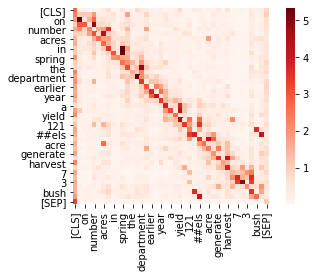

In [21]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

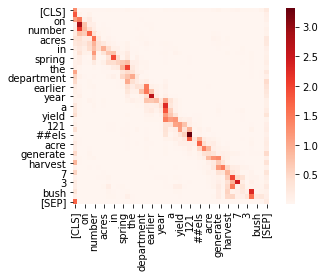

In [22]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

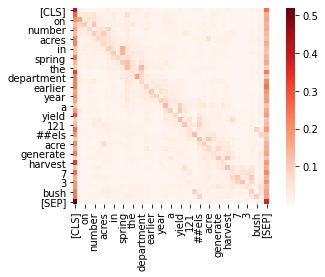

In [23]:
# Attention weight visualization (Layer-level visualization)
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

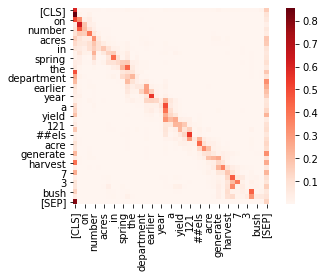

In [24]:
#Attention weight visualization (Head-level visualization)
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

##Test 2

In [25]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[1].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  5297,  1046,  1012,  1047, 10524,  2063,  1010,  5179,  2086,
          2214,  1010,  3727,  2010,  3105,  2004,  3237,  3580,  2343,  1998,
          1037,  2472,  1997,  9980,  2000,  6039,  1996,  4460,  2012, 16060,
         22684,  2747,  2218,  2011,  2957,  1043,  1012, 20911,  2386,  1010,
          2040,  2012,  6079,  1010,  2097, 11036,  2220,   102]])
['[CLS]', 'allen', 'j', '.', 'k', '##row', '##e', ',', '56', 'years', 'old', ',', 'leaves', 'his', 'job', 'as', 'executive', 'vice', 'president', 'and', 'a', 'director', 'of', 'ibm', 'to', 'fill', 'the', 'positions', 'at', 'tex', '##aco', 'currently', 'held', 'by', 'richard', 'g', '.', 'brink', '##man', ',', 'who', 'at', '61', ',', 'will', 'retire', 'early', '[SEP]']


In [26]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

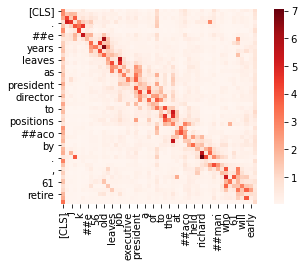

In [27]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

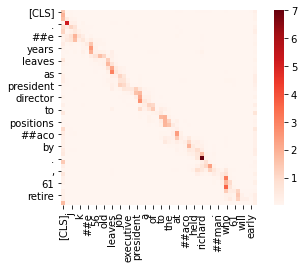

In [28]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

##Test 3

In [29]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[2].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  2720,  1012,  2417,  3877,  2038,  9240,  1037,  2307,  3074,
          1997,  5344,  1010,  2926,  1996, 20277, 16750,  2040,  2298,  2066,
          2027,  1005,  2310,  2985,  1996,  2627,  2431,  1011,  2301,  5948,
          1996,  2168,  2452,  1997,  4157,  2007,  1996,  2168,  2214, 14412,
          2015,   102]])
['[CLS]', 'mr', '.', 'red', '##ford', 'has', 'assembled', 'a', 'great', 'collection', 'of', 'faces', ',', 'especially', 'the', 'gee', '##zers', 'who', 'look', 'like', 'they', "'", 've', 'spent', 'the', 'past', 'half', '-', 'century', 'drinking', 'the', 'same', 'cup', 'of', 'coffee', 'with', 'the', 'same', 'old', 'pal', '##s', '[SEP]']


In [30]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

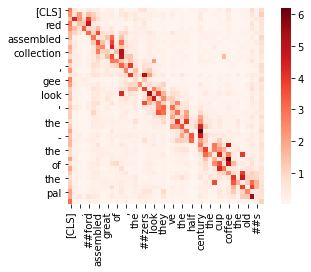

In [31]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

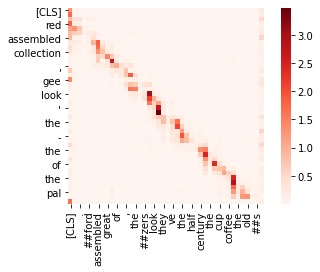

In [32]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

##Test 4

In [33]:
# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[3].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[ 101, 2045, 2020, 1050, 1005, 1056, 2151, 2137, 8664, 2988, 1010, 2021,
         1037, 1057, 1012, 1055, 1012, 2886, 7739, 4755, 2048, 3626, 2372, 2001,
         4394,  102]])
['[CLS]', 'there', 'were', 'n', "'", 't', 'any', 'american', 'casualties', 'reported', ',', 'but', 'a', 'u', '.', 's', '.', 'attack', 'helicopter', 'carrying', 'two', 'crew', 'members', 'was', 'missing', '[SEP]']


In [34]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

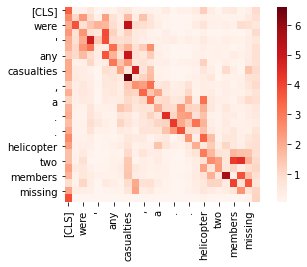

In [35]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

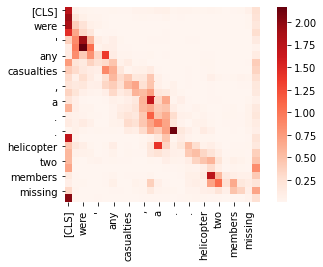

In [36]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)